In [1]:
# -*- coding: UTF-8 -*-
from __future__ import unicode_literals, division, print_function, absolute_import
from builtins import range, str, zip
import re
import os
from glob import glob
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
from sklearn.svm import LinearSVC
from gensim.models.word2vec import Word2Vec
from nlputils.features import preprocess_text
from nlputils.simmat import dist2kernel
from nlputils.embedding import proj2d
from nlputils.visualize import basic_viz, get_colors
from word_emb_sim import compute_w2v_K, transform_word2vec_featmat

py.init_notebook_mode()
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Load data and bootstrap emotion labels

In [2]:
# load posts with partially annotated categories
df = pd.read_csv("data/posts_categories.tsv", sep="\t")
posts = {}
posts_pp = {}
post_categories = {}
post_likes = {}
post_love = {}
post_haha = {}
post_sad = {}
post_wow = {}
post_angry = {}
# read in all posts and (if available) category
for i in range(len(df)):
    if not pd.isna(df.iloc[i]["link"]) and not pd.isna(df.iloc[i]["post_message"]):
        posts[df.iloc[i]["post_id"]] = df.iloc[i]["post_message"]
        # count reactions
        post_likes[df.iloc[i]["post_id"]] = df.iloc[i]["likes_count_fb"]
        post_love[df.iloc[i]["post_id"]] = df.iloc[i]["rea_LOVE"]
        post_haha[df.iloc[i]["post_id"]] = df.iloc[i]["rea_HAHA"]
        post_sad[df.iloc[i]["post_id"]] = df.iloc[i]["rea_SAD"]
        post_wow[df.iloc[i]["post_id"]] = df.iloc[i]["rea_WOW"]
        post_angry[df.iloc[i]["post_id"]] = df.iloc[i]["rea_ANGRY"]
        if not pd.isna(df.iloc[i]["Kategorien "]):
            post_categories[df.iloc[i]["post_id"]] = df.iloc[i]["Kategorien "]
            # for articles we can also extract the headline from the url
            if not df.iloc[i]["link_domain"] == "facebook.com":
                link = df.iloc[i]["link"]
                if df.iloc[i]["link_domain"] == "m.exactag.com":
                    link = link.split("bild-plus%2F")[1].replace("%2F", " ")
                else:
                    link = link.split(df.iloc[i]["link_domain"])[1]
                posts[df.iloc[i]["post_id"]] += " " + " ".join(re.findall("[A-Za-z]+", re.sub("[0-9]+.bild.html", "", link)))
        # preprocess text and manually add emojis again
        pp = preprocess_text(df.iloc[i]["post_message"])
        char_counts = Counter(list(df.iloc[i]["post_message"]))
        for c in char_counts:
            if len(c.encode("ascii", "backslashreplace")) > 5:
                pp += " " + " ".join(char_counts[c]*[c])
        posts_pp[df.iloc[i]["post_id"]] = pp

In [3]:
# read in sentiment words
df = pd.read_csv("data/GermanPolarityClues-2012/GermanPolarityClues-Negative-21042012.tsv", sep="\t", header=None)
sent_neg = set(preprocess_text(t) for t in df[0])
df = pd.read_csv("data/GermanPolarityClues-2012/GermanPolarityClues-Positive-21042012.tsv", sep="\t", header=None)
sent_pos = set(preprocess_text(t) for t in df[0])
df = pd.read_csv("data/GermanPolarityClues-2012/GermanPolarityClues-Neutral-21042012.tsv", sep="\t", header=None)
sent_neu = set(preprocess_text(t) for t in df[0])
# read in emotion words and assign to 4 emotions
# https://www.microsoft.com/developerblog/2015/11/29/emotion-detection-and-recognition-from-text-using-deep-learning/
df = pd.read_csv("data/emotion_words/Ekel.txt", sep="\t", header=None)
emo_anger = set(preprocess_text(t) for t in df[0])
df = pd.read_csv("data/emotion_words/Verachtung.txt", sep="\t", header=None)
emo_anger.update(set(preprocess_text(t) for t in df[0]))
df = pd.read_csv("data/emotion_words/Wut.txt", sep="\t", header=None)
emo_anger.update(set(preprocess_text(t) for t in df[0]))
df = pd.read_csv("data/emotion_words/Furcht.txt", sep="\t", header=None)
emo_fear = set(preprocess_text(t) for t in df[0])
df = pd.read_csv("data/emotion_words/Freude.txt", sep="\t", header=None)
emo_happy = set(preprocess_text(t) for t in df[0])
df = pd.read_csv("data/emotion_words/Ueberraschung.txt", sep="\t", header=None)
emo_happy.update(set(preprocess_text(t) for t in df[0]))
df = pd.read_csv("data/emotion_words/Trauer.txt", sep="\t", header=None)
emo_sad = set(preprocess_text(t) for t in df[0])
# define emotion emojis
# https://www.insight-centre.org/sites/default/files/publications/ianwood-emotionworkshop.pdf
emojis_happy = set("😀😃😄😁😆😅😂🤣☺😊😇🙂🙃😉😌😍😘😗😙😚😋😛😝😜🤪🤩😎😺😸😹😻😽🙌👏👍✌👌🎉❤💕💞💓💗💖♥")
emojis_sad = set("😞😔😟😕🙁☹😣😖😫😩😢😭😥😶😐😧😦😪😿🙀👎💔")
emojis_anger = set("😒😑😤😠😡🤬😾🖕💩👿")
emojis_fear = set("😱😳😨😰😵😧😮😲🙀")
emotions_list = ["happy", "sad", "fear", "anger", "-"]

def label_word_sent(w):
    sent_label = 0.
    if w in sent_neg:
        sent_label = -1.
    elif w in sent_pos:
        sent_label = +1.
    return sent_label

def label_word_emo(w):
    emo_label = "-"
    if w in emo_anger:
        emo_label = "anger"
    elif w in emo_fear:
        emo_label = "fear"
    elif w in emo_happy:
        emo_label = "happy"
    elif w in emo_sad:
        emo_label = "sad"
    return emo_label

In [4]:
# read in comments for all posts
comments = {i: {} for i in posts}
comments_pp = {i: {} for i in posts}
number_of_words = {i: {} for i in posts}
sent_scores = {i: {} for i in posts}
emo_anger_scores = {i: {} for i in posts}
emo_fear_scores = {i: {} for i in posts}
emo_sad_scores = {i: {} for i in posts}
emo_happy_scores = {i: {} for i in posts}
emo_main_label = {i: {} for i in posts}
df = pd.read_csv("data/all_comments.csv", sep="\t")
for i in range(len(df)):
    post_id, comment_message = df.iloc[i]["post_id"], df.iloc[i]["comment_message"]
    comment_id = post_id + " %i" % i
    if post_id in comments and not pd.isna(comment_message) and preprocess_text(comment_message):
        comments[post_id][comment_id] = comment_message
        pp_l = preprocess_text(comment_message)
        # based on the preprocessed words, get sentiment and word based emotion scores
        sent_scores[post_id][comment_id] = np.mean([label_word_sent(word) for word in pp_l.split()])
        emotions = Counter([label_word_emo(word) for word in pp_l.split()])
        # add scores based on emojis (from non-preprocessed text!)
        char_counts = Counter(list(comment_message))
        for c in char_counts:
            if len(c.encode("ascii", "backslashreplace")) > 5:
                pp_l += " " + " ".join(char_counts[c]*[c])
                if c in emojis_anger:
                    emotions["anger"] += char_counts[c]
                elif c in emojis_fear:
                    emotions["fear"] += char_counts[c]
                elif c in emojis_happy:
                    emotions["happy"] += char_counts[c]
                elif c in emojis_sad:
                    emotions["sad"] += char_counts[c]
        comments_pp[post_id][comment_id] = pp_l
        n_tokens = len(pp_l.split())
        number_of_words[post_id][comment_id] = n_tokens
        emotions["-"] = 0
        emo_main_label[post_id][comment_id] = max(emotions, key=emotions.get)
        emo_anger_scores[post_id][comment_id] = emotions["anger"]/n_tokens
        emo_fear_scores[post_id][comment_id] = emotions["fear"]/n_tokens
        emo_sad_scores[post_id][comment_id] = emotions["sad"]/n_tokens
        emo_happy_scores[post_id][comment_id] = emotions["happy"]/n_tokens

## Refine labels

### Train word2vec embeddings

In [5]:
# get all comments and posts as lists of lists
sentences = []
for post_id in posts_pp:
    posts_pp[post_id] = posts_pp[post_id].split()
    sentences.append(posts_pp[post_id])
    for i in comments_pp[post_id]:
        comments_pp[post_id][i] = comments_pp[post_id][i].split()
        sentences.append(comments_pp[post_id][i])

In [6]:
# train word2vec model
model = Word2Vec(sentences, size=100, window=10, min_count=3, workers=4)
word_vectors = model.wv
del model
word_vectors.init_sims(replace=True)

In [7]:
word_vectors.most_similar(positive=['🙈'])

[('😅', 0.7879248857498169),
 ('🙊', 0.7708940505981445),
 ('🙉', 0.6665292382240295),
 ('🙄', 0.5988636016845703),
 ('😜', 0.5948917865753174),
 ('😄', 0.5707231760025024),
 ('😂', 0.548179030418396),
 ('😳', 0.5220922827720642),
 ('😬', 0.5129526853561401),
 ('\U0001f92a', 0.5123497247695923)]

### Get missing post categories

In [8]:
train_ids = sorted(post_categories.keys())
test_ids = sorted([p for p in posts.keys() if not p in train_ids])
posts_train = transform_word2vec_featmat(posts_pp, train_ids, word_vectors, avg='simple avg')
posts_test = transform_word2vec_featmat(posts_pp, test_ids, word_vectors, avg='simple avg')
y = np.array([post_categories[p] for p in train_ids])
clf = LinearSVC(class_weight='balanced')
clf.fit(posts_train, y)
print(np.mean(y==clf.predict(posts_train)))
y_pred_test = clf.predict(posts_test)
for i, pid in enumerate(test_ids):
    post_categories[pid] = y_pred_test[i]

0.8524590163934426


In [9]:
# visualize posts
ids = train_ids + test_ids
textdict = {did: "<br>".join([" ".join(posts[did].split()[i:min(i+5, len(posts[did].split()))]) for i in range(0, len(posts[did].split()), 5)]) for did in ids}
# compute similarities and embedding (choose from sim="simple avg", "simple max", "greedy")
S = compute_w2v_K(ids, posts_pp, word_vectors, sim="simple avg")
S -= S.min()
S /= S.max()
D = 1.-S
S = dist2kernel(D)
x, y = proj2d(S, use_tsne=True, verbose=True)

performing tSNE: 1418 datapoints
Iteration 25: error is 4.41353
Iteration 50: error is 4.37516
Iteration 75: error is 4.52444
Iteration 100: error is 4.62042
Iteration 125: error is 2.68336
Iteration 150: error is 2.26430
Iteration 175: error is 2.17007
Iteration 200: error is 2.13760
Iteration 225: error is 2.11562
Iteration 250: error is 2.09934
Iteration 275: error is 2.07762
Iteration 300: error is 2.06229
Iteration 325: error is 2.05209
Iteration 350: error is 2.04490
Iteration 375: error is 2.03884
Iteration 400: error is 2.03385
Iteration 425: error is 2.02976
Iteration 450: error is 2.02596
Iteration 475: error is 2.02324
Iteration 500: error is 2.02143
Iteration 525: error is 2.02013
Iteration 550: error is 2.01885
Iteration 575: error is 2.01794
Iteration 600: error is 2.01703
Iteration 625: error is 2.01631
Iteration 650: error is 2.01551
Iteration 675: error is 2.01504
Iteration 700: error is 2.01467
Iteration 725: error is 2.01409
Iteration 750: error is 2.01332
Iteration 

In [10]:
def create_fig_cats(doc_ids, doccats, x, y, textdict, title):
    categories = sorted(set(doccats.values()))
    colorlist = get_colors(len(categories))
    colordict = {cat: "rgb(%i,%i,%i)" % (255 * colorlist[i][0], 255 * colorlist[i][1], 255 * colorlist[i][2]) for i, cat in enumerate(categories)}
    data = []
    for j, cat in enumerate(categories):
        # get docids that belong to the current category
        didx_temp = [i for i, did in enumerate(doc_ids) if cat == doccats[did]]
        trace = go.Scatter(
                    x=x[didx_temp],
                    y=y[didx_temp],
                    mode='markers',
                    marker=dict(
                        size='10',
                        opacity=0.6,
                        color=colordict[cat]
                    ),
                    text=[textdict[did] for did in doc_ids if cat == doccats[did]],
                    hoverinfo='text',
                    name=cat
                )
        data.append(trace)
    layout = go.Layout(
                title=title,
                hovermode='closest',
                xaxis=dict(zeroline=False),
                yaxis=dict(zeroline=False),
                showlegend=True
             )
    fig = go.Figure(data=data, layout=layout)
    return fig

def create_fig_scores(doc_ids, docscores, x, y, textdict, title):
    trace = go.Scatter(
                    x = x,
                    y = y,
                    mode = 'markers',
                    marker=dict(
                        size='10',
                        opacity=0.8,
                        color = [docscores[i] for i in ids],
                        showscale=True
                    ),
                    text = [textdict[i] for i in ids],
                    hoverinfo='text'
            )
    data = [trace]
    layout = go.Layout(
                title=title,
                hovermode='closest',
                xaxis=dict(zeroline=False),
                yaxis=dict(zeroline=False)
             )
    fig = go.Figure(data=data, layout=layout)
    return fig

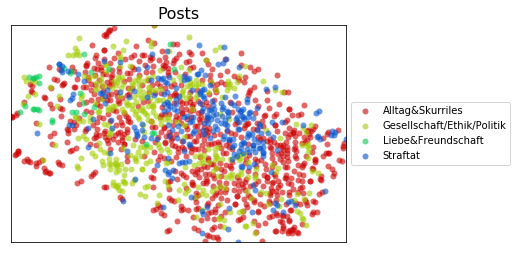

In [11]:
# basic non-interactive plot
categories = sorted(set(post_categories.values()))
basic_viz(ids, post_categories, x, y, dict(zip(categories, categories)), "Posts")

In [12]:
# interactive plots
fig_cats = create_fig_cats(ids, post_categories, x, y, textdict, "Posts")
py.iplot(fig_cats)

### Relabel comments with emotions

In [13]:
post_ids = sorted(posts.keys())
print("getting comment vectors")
comment_vectors = [transform_word2vec_featmat(comments_pp[p], sorted(comments_pp[p]), word_vectors, avg='simple avg') for p in post_ids]
print("getting comment labels")
y = []
for p in post_ids:
    y.extend([emo_main_label[p][c] for c in sorted(emo_main_label[p])])
y = np.array(y)
print("training clf")
clf = LinearSVC(class_weight='balanced')
clf.fit(np.vstack(comment_vectors), y)
print(np.mean(y==clf.predict(np.vstack(comment_vectors))))
print("generating new labels")
for i, p in enumerate(post_ids):
    y_pred_test = clf.predict(comment_vectors[i])   
    for j, c in enumerate(sorted(emo_main_label[p])):
        emo_main_label[p][c] = y_pred_test[j]

getting comment vectors


/home/franzi/Documents/code/emotion_anaysis/word_emb_sim.py:161: RuntimeWarning:

invalid value encountered in true_divide



getting comment labels
training clf
0.7054919091491942
generating new labels


In [14]:
# visualize
pid = post_ids[5]
print(posts[pid])
print(post_categories[pid])
ids = np.random.permutation(list(comments_pp[pid]))[:3000]
textdict = {did: "<br>".join([" ".join(comments[pid][did].split()[i:min(i+5, len(comments[pid][did].split()))]) for i in range(0, len(comments[pid][did].split()), 5)]) for did in ids}
# compute similarities and embedding (choose from sim="simple avg", "simple max", "greedy")
S = compute_w2v_K(ids, comments_pp[pid], word_vectors, sim="simple avg")
S -= S.min()
S /= S.max()
D = 1.-S
S = dist2kernel(D)
x, y = proj2d(S, use_tsne=True, verbose=True)

Mit verschränkten Armen sitzt Dimitri K. im Gerichtssaal. Was er von der Polizei hält  trägt er in seinem Gesicht provokant als Tattoo zur Schau: „Fuck Cops“.
Straftat


/home/franzi/Documents/code/emotion_anaysis/word_emb_sim.py:161: RuntimeWarning:

invalid value encountered in true_divide



performing tSNE: 419 datapoints
Iteration 25: error is 4.10813
Iteration 50: error is 3.99954
Iteration 75: error is 4.23413
Iteration 100: error is 4.18234
Iteration 125: error is 1.85969
Iteration 150: error is 1.38178
Iteration 175: error is 1.25499
Iteration 200: error is 1.20185
Iteration 225: error is 1.16270
Iteration 250: error is 1.15640
Iteration 275: error is 1.13709
Iteration 300: error is 1.13185
Iteration 325: error is 1.12435
Iteration 350: error is 1.11862
Iteration 375: error is 1.11495
Iteration 400: error is 1.11264
Iteration 425: error is 1.11191
Iteration 450: error is 1.11032
Iteration 475: error is 1.10857
Iteration 500: error is 1.10524
Iteration 525: error is 1.10438
Iteration 550: error is 1.10392
Iteration 575: error is 1.10374
Iteration 600: error is 1.10349
Iteration 625: error is 1.10337
Iteration 650: error is 1.10306
Iteration 675: error is 1.10293
Iteration 700: error is 1.10287
Iteration 725: error is 1.10287
Iteration 750: error is 1.10287
Iteration 7

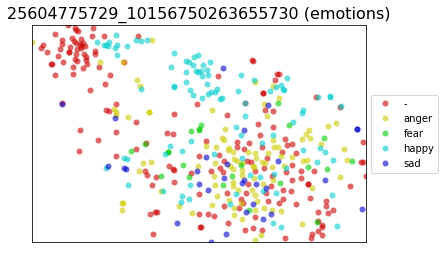

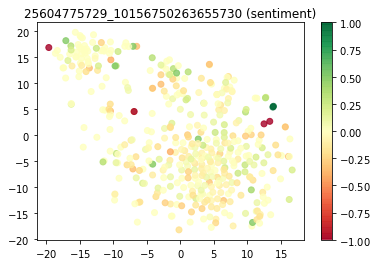

In [15]:
# basic non-interactive plot with emotions and sentiment coloring
basic_viz(ids, emo_main_label[pid], x, y, dict(zip(emotions_list, emotions_list)), pid + " (emotions)")
plt.figure()
plt.scatter(x, y, c=[sent_scores[pid][i] for i in ids], alpha=0.8, cmap="RdYlGn")
plt.colorbar()
plt.title(pid + " (sentiment)");

In [16]:
# interactive plots
fig_emo = create_fig_cats(ids, emo_main_label[pid], x, y, textdict, pid + " (emotions)")
fig_sent = create_fig_scores(ids, sent_scores[pid], x, y, textdict, pid + " (sentiment)")

py.iplot(fig_emo)
py.iplot(fig_sent)

### Compute basic stats

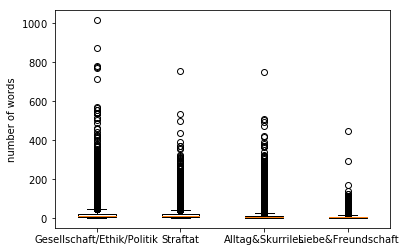

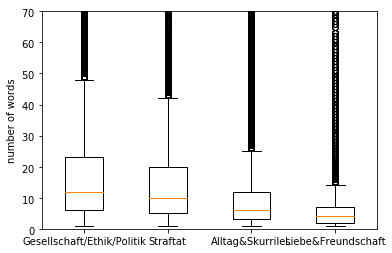

In [17]:
# number of words in comments based on post category
n_words = []
categories = ['Gesellschaft/Ethik/Politik', 'Straftat', 'Alltag&Skurriles', 'Liebe&Freundschaft']
for post_cat in categories:
    n_words.append([number_of_words[pid][i] for pid in number_of_words for i in number_of_words[pid] if post_categories[pid] == post_cat])
plt.figure()
plt.boxplot(n_words, labels=categories)
plt.ylabel("number of words")
plt.figure()
plt.boxplot(n_words, labels=categories)
plt.ylabel("number of words")
plt.ylim([0,70]);

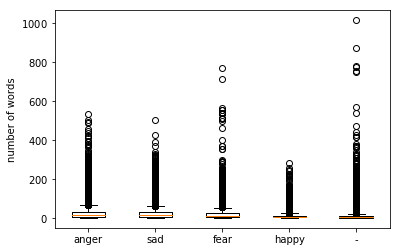

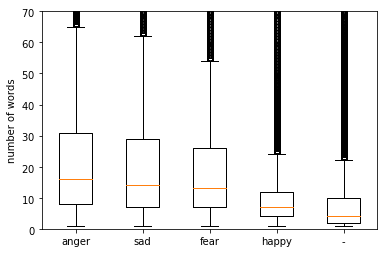

In [18]:
# number of words in comments based on comment emotion
n_words = []
for emo in ["anger", "sad", "fear", "happy", "-"]:
    n_words.append([number_of_words[pid][i] for pid in number_of_words for i in number_of_words[pid] if emo_main_label[pid][i] == emo])
plt.figure()
plt.boxplot(n_words, labels=["anger", "sad", "fear", "happy", "-"])
plt.ylabel("number of words")
plt.figure()
plt.boxplot(n_words, labels=["anger", "sad", "fear", "happy", "-"])
plt.ylabel("number of words")
plt.ylim([0,70]);

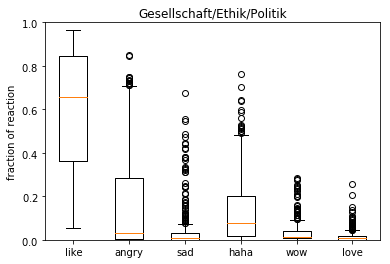

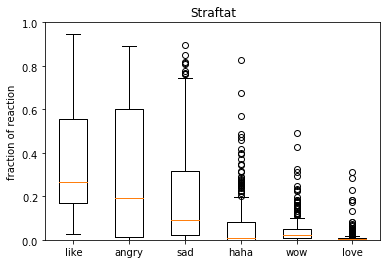

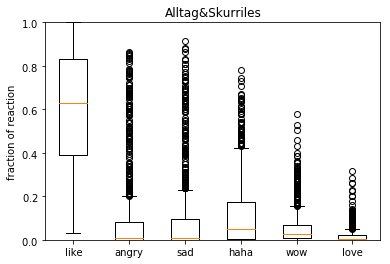

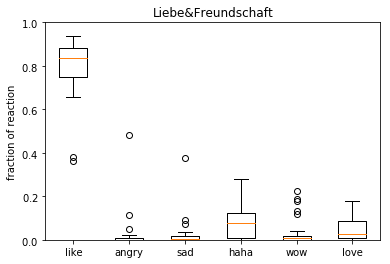

In [19]:
# reactions based on post category
for post_cat in categories:
    reactions = {"like": [], "love": [], "sad": [], "haha": [], "angry": [], "wow": []}
    for pid in post_categories:
        if post_categories[pid] == post_cat:
            r_total = post_likes[pid] + post_love[pid] + post_sad[pid] + post_haha[pid] + post_angry[pid] + post_wow[pid]
            reactions["like"].append(post_likes[pid]/r_total)
            reactions["love"].append(post_love[pid]/r_total)
            reactions["sad"].append(post_sad[pid]/r_total)
            reactions["haha"].append(post_haha[pid]/r_total)
            reactions["angry"].append(post_angry[pid]/r_total)
            reactions["wow"].append(post_wow[pid]/r_total)
    r_labels = ["like", "angry", "sad", "haha", "wow", "love"]
    reactions = [reactions[r] for r in r_labels]
    plt.figure()
    plt.boxplot(reactions, labels=r_labels)
    plt.ylabel("fraction of reaction")
    plt.title(post_cat)
    plt.ylim([0,1]);

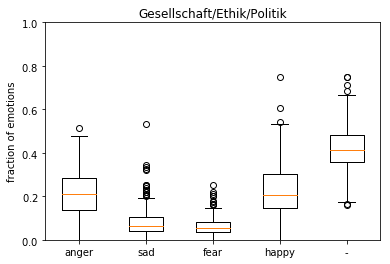

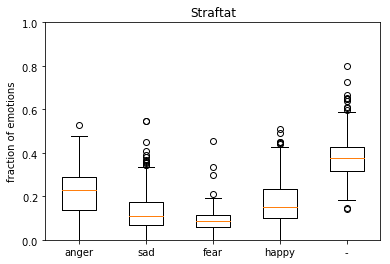

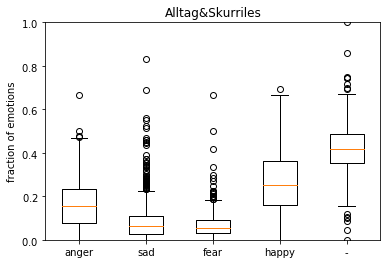

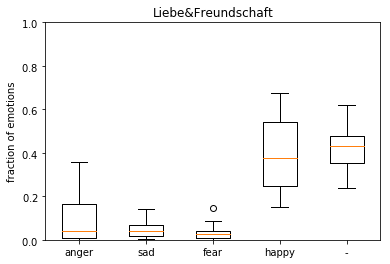

In [20]:
# emotions based on post category
emotions = ["anger", "sad", "fear", "happy", "-"]
for post_cat in categories:
    reactions = {e: [] for e in emotions}
    for pid in post_categories:
        if post_categories[pid] == post_cat:
            r_total = len(emo_main_label[pid])
            for emo in emotions:
                reactions[emo].append(sum([1 for i in emo_main_label[pid] if emo_main_label[pid][i] == emo])/r_total)
    reactions = [reactions[r] for r in emotions]
    plt.figure()
    plt.boxplot(reactions, labels=emotions)
    plt.ylabel("fraction of emotions")
    plt.title(post_cat)
    plt.ylim([0,1]);